Load Packages

In [1]:
import numpy as np
import wandb
import random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchinfo import summary
from torchvision import transforms, models
from material import MyDataset

Control Randomness for Reproductability

In [2]:
torch.manual_seed(1919)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(1919)
random.seed(1919)

Select CUDA

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Adjust p-value for Data Augmentation for each class

In [2]:
# def transform(proba):
#     t = transforms.Compose([
#         transforms.Resize((224, 224)),
#         transforms.RandomHorizontalFlip(p=proba),
#         transforms.RandomVerticalFlip(p=proba),
#         transforms.ToTensor(),
#         transforms.Normalize(
#             [0.485, 0.456, 0.406],
#             [0.229, 0.224, 0.225]
#         )
#     ])
#     return t

In [5]:
# def transform(proba):
#     t = transforms.Compose([
#         transforms.Resize((224, 224)),
#         transforms.RandomHorizontalFlip(p=proba),
#         transforms.RandomVerticalFlip(p=proba),
#         transforms.ToTensor(),
#         transforms.Normalize(
#             [0.485, 0.456, 0.406],
#             [0.229, 0.224, 0.225]
#         )
#     ])
#     return t

In [6]:
# trainsets = []
# dirs = ["leather/", "mesh_knit/", "suede/", "nylon/"]
# prob = [0.25, 0.5, 1, 0.75]

# for i in range(4):
#     dataset = MyDataset(dir='/home/compu/Documents/exports/material_merge/train/'+dirs[i],
#                         image_ids='/home/compu/Documents/exports/newfile_material_merge.json',
#                         transforms=transform(prob[i]))
#     trainsets.append(dataset)
#     print(len(dataset))

# trainset = torch.utils.data.ConcatDataset(trainsets)

Load Train/Test Dataset & Normalization

In [4]:
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

trainset = MyDataset(dir='/home/compu/Documents/exports/material_merge/train/',
                     image_ids='/home/compu/Documents/exports/newfile_material_merge.json',
                     transforms=transforms_train)

testset = MyDataset(dir='/home/compu/Documents/exports/material_merge/test/',
                    image_ids='/home/compu/Documents/exports/newfile_material_merge.json',
                    transforms=transforms_test)

train_loader = DataLoader(trainset, batch_size=16, num_workers=8)
test_loader = DataLoader(testset, batch_size=16, num_workers=8)

print('학습 데이터셋 크기:', len(trainset))
print('테스트 데이터셋 크기:', len(testset))

학습 데이터셋 크기: 8409
테스트 데이터셋 크기: 2701


EarlyStopping Class for pytorch

In [5]:
class EarlyStopping:
    """Early stops the training if loss doesn't improve after a given patience."""
    def __init__(self, patience=10, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when loss decrease.'''
        if self.verbose:
            self.trace_func(f'loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

Define Transfer Learning Model

In [6]:
class MyModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.model = models.vit_b_16(True)
        self.classifier = nn.Linear(1000, 4)

    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return x

model = MyModel().to(device)
print(summary(model, input_size=(1, 3, 224, 224)))

Layer (type:depth-idx)                             Output Shape              Param #
MyModel                                            [1, 4]                    --
├─VisionTransformer: 1-1                           [1, 1000]                 768
│    └─Conv2d: 2-1                                 [1, 768, 14, 14]          590,592
│    └─Encoder: 2-2                                [1, 197, 768]             151,296
│    │    └─Dropout: 3-1                           [1, 197, 768]             --
│    │    └─Sequential: 3-2                        [1, 197, 768]             85,054,464
│    │    └─LayerNorm: 3-3                         [1, 197, 768]             1,536
│    └─Sequential: 2-3                             [1, 1000]                 --
│    │    └─Linear: 3-4                            [1, 1000]                 769,000
├─Linear: 1-2                                      [1, 4]                    4,004
Total params: 86,571,660
Trainable params: 86,571,660
Non-trainable params: 0
Total m

Model Parameter Freeze for Transfer Learning

In [10]:
# for name, param in model.named_parameters():
#     if 'bn' in name:
#         param.requires_grad = True
#     elif name.startswith(('model.fc', 'classifier')):
#         param.requires_grad = True
#     else:
#         param.requires_grad = False
#     print(name, param.requires_grad)
        

In [21]:
# for param in model.parameters():
#     param.requires_grad = False

# for param in model.model.head.parameters():
#     param.requires_grad = True

Pytorch Focal Loss function

In [22]:
def focal_binary_cross_entropy(logits, targets, gamma=2):
    num_label = 4
    l = logits.reshape(-1)
    t = targets.reshape(-1)
    p = torch.sigmoid(l)
    p = torch.where(t >= 0.5, p, 1-p)
    logp = - torch.log(torch.clamp(p, 1e-4, 1-1e-4))
    loss = logp*((1-p)**gamma)
    loss = num_label*loss.mean()
    return loss

Model Training

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
#criterion = focal_binary_cross_entropy
criterion = nn.MultiLabelSoftMarginLoss()
num_epochs = 100
train_loss = 0
train_acc = 0
test_loss = 0
test_acc = 0

wandb.init(project="kristin", name="vit-b/Adam0.001/1919")
wandb.watch(model, criterion, log='all', log_freq=10)


# early_stopping 객체 선언(5번의 epoch 연속으로 loss 미개선 시에 조기 종료 예시)
# early_stopping = EarlyStopping(patience = 10, verbose = True, path = "material1.pt")

for epoch in range(num_epochs):

    model.train()

    for i, (images, targets) in enumerate(train_loader):
        optimizer.zero_grad()

        images = images.to(device)
        targets = targets.to(device)

        outputs = model(images)
        loss = criterion(outputs, targets)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        
        outputs = (outputs > 0.5).float()
        acc = (outputs == targets).float().mean()
        train_acc += acc

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    model.eval()
    
    for i, (images, targets) in enumerate(test_loader):
        images2 = images.to(device)
        targets2 = targets.to(device)
        
        outputs2 = model(images2)
        loss2 = criterion(outputs2, targets2)

        test_loss += loss2.item()
        outputs2 = (outputs2 > 0.5).float()
        acc = (outputs2 == targets2).float().mean()
        test_acc += acc

    test_loss /= len(test_loader)
    test_acc /= len(test_loader)
    
    metrics = {"train_loss": train_loss,
                "train_accuracy": train_acc,
                "test_loss": test_loss,
                "test_accuracy": test_acc}
    print("[" + epoch + "/" + num_epochs + "]")
    wandb.log(metrics)
    # early_stopping(loss.item(), model) # 수렴 earlystop 체크
    
    # if early_stopping.early_stop: # 조건 만족 시 조기 종료
    #     break

test_accuracy,▁▂▂▃▃▃▄▄▆▆▇▆▇▇▇▇▇▇▇▇█▇█▇█▇██▇▇▇██▇██████
test_loss,▄▃▄▁▅▅▃▇▇▃▄▄▃▄▂▄▁▅▂▁▂█▄▂▁▄▃▂▃▃▃▄▃▂▂▂▃▂▄▃
train_accuracy,▁▂▃▄▅▆▇▇▇▇▇▇████████████████████████████
train_loss,█▇▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,0.91201
test_loss,0.45884
train_accuracy,0.99268
train_loss,0.02471


KeyboardInterrupt: 

In [18]:
model.eval()

with torch.no_grad():
    preds_list = []
    y_list = []

    for i, (images, targets) in enumerate(test_loader):
        images = images.to(device)
        targets = targets.to(device)
        outputs = model(images)
        loss = criterion(outputs, targets)

        outputs = torch.sigmoid(outputs).float()        
        preds_list.append(outputs.cpu())
        y_list.append(targets.cpu())
    
    preds_list = np.concatenate(preds_list)
    y_list = np.concatenate(y_list)

wandb.finish()

In [25]:
import sklearn.metrics as skm
from sklearn.metrics import multilabel_confusion_matrix

print(skm.classification_report(y_list, preds_list))
matrix = multilabel_confusion_matrix(y_list, preds_list)
result = [mat.diagonal().sum() / mat.sum() for mat in matrix]
print(result)

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1983
           1       0.91      0.90      0.90      1319
           2       0.89      0.75      0.82       871
           3       0.94      0.78      0.85       428

   micro avg       0.90      0.88      0.89      4601
   macro avg       0.91      0.84      0.87      4601
weighted avg       0.90      0.88      0.89      4601
 samples avg       0.87      0.86      0.86      4601

[0.8763420955201777, 0.9033691225472047, 0.8904109589041096, 0.9566827101073676]


/home/compu/anaconda3/envs/kristin/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


모델 저장 불러오기

In [18]:
# 모델 저장
torch.save(model.state_dict(), "/home/compu/Documents/kristin/material/model_ViT.pt")

저장된 모델 불러오기

In [10]:
# 모델 불러오기 전 정의
class MyModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.model = models.vit_b_16(pretrained=True)
        self.classifier = nn.Linear(1000, 4)

    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)

        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MyModel().to(device)
print(summary(model, input_size=(1, 3, 224, 224), verbose=0))

Layer (type:depth-idx)                             Output Shape              Param #
MyModel                                            [1, 4]                    --
├─VisionTransformer: 1-1                           [1, 1000]                 768
│    └─Conv2d: 2-1                                 [1, 768, 14, 14]          590,592
│    └─Encoder: 2-2                                [1, 197, 768]             151,296
│    │    └─Dropout: 3-1                           [1, 197, 768]             --
│    │    └─Sequential: 3-2                        [1, 197, 768]             85,054,464
│    │    └─LayerNorm: 3-3                         [1, 197, 768]             1,536
│    └─Sequential: 2-3                             [1, 1000]                 --
│    │    └─Linear: 3-4                            [1, 1000]                 769,000
├─Linear: 1-2                                      [1, 4]                    4,004
Total params: 86,571,660
Trainable params: 86,571,660
Non-trainable params: 0
Total m

In [14]:
# 모델 불러오기
model.load_state_dict(torch.load('model_ViT.pt'))

<All keys matched successfully>

In [17]:
model.eval()
criterion = nn.MultiLabelSoftMarginLoss()

with torch.no_grad():
    preds_list = []
    y_list = []

    for i, (images, targets) in enumerate(test_loader):
        images = images.to(device)
        targets = targets.to(device)
        outputs = model(images)
        loss = criterion(outputs, targets)

        outputs = torch.sigmoid(outputs).float()        
        preds_list.append(outputs.cpu())
        y_list.append(targets.cpu())
    
    preds_list = np.concatenate(preds_list)
    y_list = np.concatenate(y_list)

In [19]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
thresholds = dict()
roc_auc = dict()
optimal_threshold = dict()

for i in range(4):
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_list[:, i], preds_list[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    optimal_idx = np.argmax(tpr[i] + fpr[i])
    optimal_threshold[i] = thresholds[optimal_idx]
    print(optimal_threshold[i])

KeyError: 772

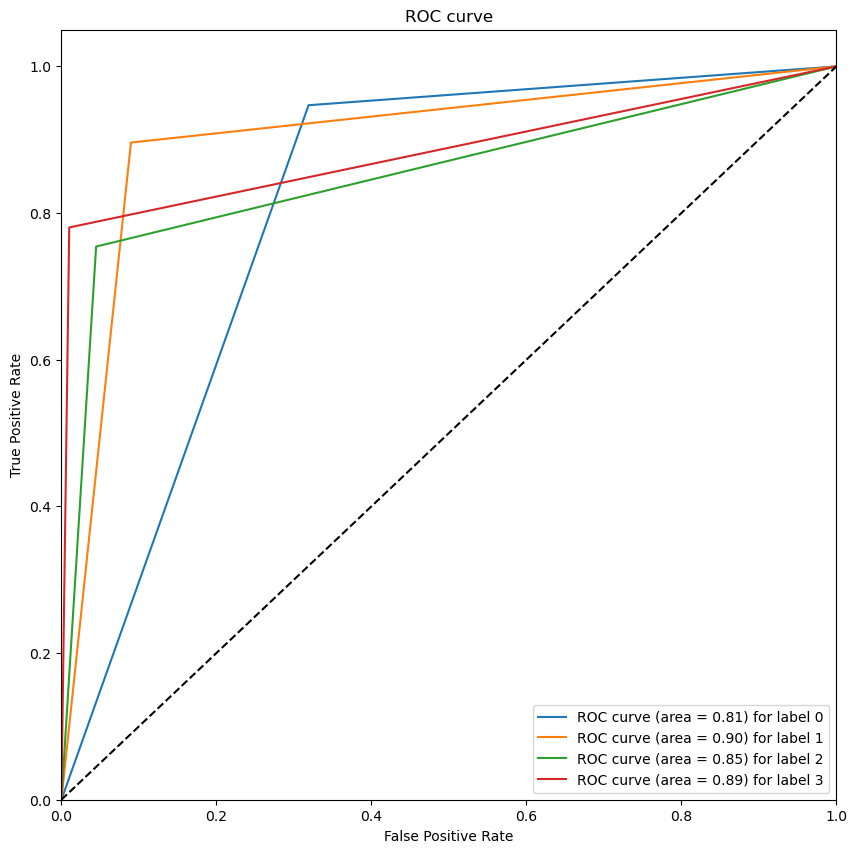

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

for i in range(4):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %d' % (roc_auc[i], i))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()